In [2]:
import os,sys,time,math,pickle
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, SparsePCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from scipy.stats import pearsonr
from scipy import signal

In [3]:
def detrend(data, normalize=False):
    '''
    Regress out the deterministic mean and linear trend by ROI-wise regression.
    
    >>> INPUT
    
    - data: 3d numpy array, nsub x ntime x nroi.
    
    >>> OUTPUT
    
    - data: 3d numpy array, nsub x ntime x nroi.
    '''
    if len(data.shape)==1:
        data = data[np.newaxis,:,np.newaxis]
    
    nsub, ntime, nroi = data.shape
    X = np.arange(1,ntime+1)[:,np.newaxis]
    X[:,0] = X[:,0] - np.mean(X[:,0])
    if normalize:
        X[:,0] = X[:,0] / np.std(X[:,0].squeeze())
    for s in range(nsub):
        for r in range(nroi):
            Y = data[s,:,r]
            model = LinearRegression(fit_intercept=True,
                                     normalize=False).fit(X,Y)
            data[s,:,r] = Y - model.predict(X)
    
    return data

In [4]:
# Test for the existence of unit roots
def find_integration_order(data, pval_bound=0.05):
    if type(data)==np.ndarray:
        data = data.tolist()
        for s in range(len(data)):
            data[s] = np.asarray(data[s])
    
    assert(type(data)==list)
    nsub = len(data)
    ords = []
    for s in range(nsub):
        if len(data[s].shape)<2:
            data[s] = data[s][:,np.newaxis]
        
        ntime = data[s].shape[0]
        nroi = data[s].shape[1]
        tmp = np.zeros((nroi))
        for r in range(nroi):
            pval = 1
            ndiff = -1
            while pval >= pval_bound:
                ndiff = ndiff + 1
                pval = adfuller(np.diff(data[s][:,r], n=ndiff))[1]
                # adfuller
                # null hypothesis: there is a unit root (pval(0.3) >= pval_bound(0.05))
                # alternative: there is no unit root (pval(0.001) < pval_bound(0.05))

            tmp[r] = ndiff
        
        ords.append(tmp)
    
    return ords

In [5]:
def pca_everything(data, algorithm='PCA', n_components=5):
    if algorithm == "PCA":
        decomp = PCA(n_components=n_components, 
                     svd_solver = 'full', whiten=False)
    elif algorithm == "SparsePCA":
        decomp = SparsePCA(n_components=n_components, 
                           normalize_components=True)
    elif algorithm == "LatentFactor":
        decomp = FactorAnalysis(n_components=n_components)
    
    nsub = data.shape[0]
    f = []; U = []; epsilon = []
    
    for s in range(nsub):
        Y = data[s,:,:].squeeze() # ntime x nroi
        est = decomp.fit(Y); 
        
        U.append(est.components_.T) # nroi x nfactor
        
        if algorithm == "PCA":
            f.append(Y @ U[s]) # f_all: ntime x nfactor
        elif algorithm == "SparsePCA":
            f.append(est.transform(Y))
        elif algorithm == "LatentFactor":
            f.append(est.transform(Y))
        
        epsilon.append(Y - f[s] @ U[s].T)

    return f, U, epsilon

In [6]:
def fvar(factors, maxlag=2, independent=True):
    '''
    Fit vector autoregressive model for factors.
    
    >>> INPUT
    
    - factors: 2d numpy array, ntime x nfactor
    - maxlag: optional (default=2)
    - independent: optional (default=True), if the factors are independent
    
    >>> OUTPUT
    
    - phi1
    - phi2
    - errs: (ntime-maxlag) x nfactor
        
    >>> DEPENDENCIES
    
    - statsmodels.tsa.api.VAR
    - statsmodels.tsa.ar_model.AR
    - numpy
    
    >>> NOTES
    
    - Assumptions: Factors are stationary. Errors are stationary.
    
    '''
    nfactor = factors.shape[1]
    ntime = factors.shape[0]
    if independent:
        phi1 = np.zeros((nfactor))
        phi2 = np.zeros((nfactor))
        errs = np.zeros((ntime-maxlag, nfactor))
        fitted = np.zeros((ntime-maxlag, nfactor))
        for f in range(nfactor):
            model = AR(factors[:,f]).fit(maxlag=maxlag, trend='nc')
            phi1[f], phi2[f] = model.params
            errs[:,f] = factors[maxlag:,f] - model.fittedvalues
            fitted[:,f] = model.fittedvalues
        
        phi1 = np.diag(phi1)
        phi2 = np.diag(phi2)
    else:
        model = VAR(factors).fit(maxlag)
        phi1 = model.coefs[0,:,:].squeeze()
        phi2 = model.coefs[1,:,:].squeeze()
        errs = model.resid
        fitted = model.fittedvalues
    
    return phi1, phi2, errs, fitted

In [7]:
def dynamic_factor_model(Y, U):
    '''
    Perform linear regression on task-related data using factor 
    loading matrix estimated from resting state data.
    
    >>> INPUT
    
    - Y: 2d numpy array, ntime x nroi
    - U: 2d numpy array, nroi x nfactor
    
    >>> OUTPUT
    
    - factors: 2d numpy array, ntime x nfactor
    - epsilon: 2d numpy array, ntime x nroi
    ---
    
    >>> NOTES
    
    - 'PCA': using pca estimation by assuming the data are stationary.
    ---
    '''
    factors = Y @ U
    epsilon = Y - factors @ U.T
    
    return factors, epsilon

In [8]:
def variance_explained(data, loadings, factors):
    '''
    >>> INPUT
    
    - data: ntime x nroi
    - loadings: nroi x nfactor
    - factors: ntime x nfactor
    '''
    dfm = loadings @ np.cov(factors.T) @ loadings.T
    cov = np.cov(data.T)
    exp_pct = np.linalg.norm(dfm) / np.linalg.norm(cov)
    return exp_pct

In [9]:
def matrix_global_diff(ref,new):
    D = new @ np.linalg.inv(ref)
    evals = np.linalg.eig(D)[0]
    out = np.sqrt(np.sum(np.square(np.log(np.abs(evals[evals>0])))))
    return out

In [10]:
def sliding_window(ts_data, width=15, stepsize=1):
    '''
    Returns a sliding window (of width n) over data from the iterable.
    s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...


    >>> INPUT

    - ts_data: numpy 2darray, nroi x ntime.
    - wlen: int
    - shift: int

    >>> OUTPUT

    - win_data: list of numpy 2darray (nroi x width)

    '''
    assert(width>0)
    nroi = ts_data.shape[0]
    npad = math.floor(width/2)

    pad_data = np.hstack((np.zeros((nroi,npad)),
                          ts_data,np.zeros((nroi,npad))))
    nt = pad_data.shape[1]

    start = np.arange(0, nt-width+1, stepsize)
    nwin = start.shape[0]

    win_data = []
    for nw in range(nwin):
        win_data.append(pad_data[:,start[nw]:start[nw]+width])

    return win_data


def calc_conn(win_data):
    '''
    Calculate connectivity.


    >>> REQUIRED INPUT

    - data: numpy 2darray, nroi x ntime


    >>> OPTIONAL INPUT

    - method
    - binary
    - ztransformed
    - diagval

    >>> OUTPUT

    - conn: numpy 2darray, nroi x nroi

    '''
    conn = []
    for data in win_data:
        conn.append(np.cov(data)[:,:,np.newaxis])
    
    conn = np.concatenate(conn, axis=2)
    
    return conn

## Preprocessing

In [14]:
# Read data
wd = '/Users/meini/data/rfMRI_roi_mean/AAL90/REST1'
filelist = [f for f in os.listdir(wd) if 'csv' in f]
data_rest = []
nload = 100
for i in range(min(len(filelist), nload)):
    fpath = wd+'/'+filelist[i]
    data_rest.append(np.genfromtxt(fpath, delimiter=',').T)

data_rest = np.asarray(data_rest) # nsub, ntime, nroi
data_rest = np.moveaxis(data_rest,[0,2],[2,0]) # nroi x ntime x nsub
print(data_rest.shape)
nroi,ntime,nsub = data_rest.shape

(90, 1200, 100)


In [ ]:
nfactor = 5

In [10]:
data_rest = detrend(data_rest)

(5, 1200, 90)


## Analysis in the ROI Level

1. Observed mean and variance for each subject at each ROI

(90, 100)
-1.6759334660794896e-13
1.8441100498497083e-13


(array([[ 0.,  0.,  1., 13., 50., 18.,  6.,  2.,  0.,  0.],
        [ 0.,  1.,  1.,  7., 38., 40.,  3.,  0.,  0.,  0.],
        [ 0.,  1.,  3.,  7., 46., 29.,  4.,  0.,  0.,  0.],
        [ 0.,  0.,  1., 10., 38., 34.,  5.,  2.,  0.,  0.],
        [ 0.,  0.,  1.,  9., 44., 27.,  8.,  1.,  0.,  0.],
        [ 0.,  0.,  1., 10., 44., 31.,  4.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 14., 43., 28.,  5.,  0.,  0.,  0.],
        [ 0.,  0.,  1., 12., 46., 26.,  2.,  1.,  1.,  1.],
        [ 0.,  0.,  5.,  6., 48., 30.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  7., 52., 23.,  6.,  0.,  1.,  0.],
        [ 0.,  0.,  2.,  7., 46., 28.,  7.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 10., 52., 23.,  5.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 10., 46., 27.,  6.,  1.,  0.,  0.],
        [ 0.,  0.,  0., 10., 41., 35.,  3.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  8., 50., 27.,  3.,  1.,  0.,  0.],
        [ 1.,  0.,  1.,  7., 44., 33.,  3.,  1.,  0.,  0.],
        [ 0.,  0.,  1., 15., 41., 29.,  

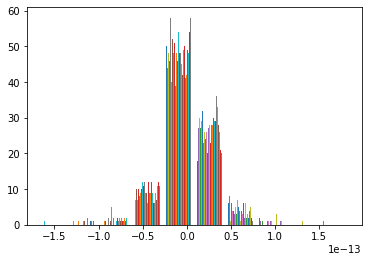

In [20]:
obs_mean = np.mean(data_rest,axis=1)
print(obs_mean.shape)
print(obs_mean.min())
print(obs_mean.max())
plt.hist(obs_mean)

2. Observed variance

(90, 100)
49.29720960595723
17686.088132545858


(array([[70., 14.,  5.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35., 26., 11., 10.,  3.,  4.,  1.,  0.,  0.,  0.],
        [51., 27.,  8.,  2.,  2.,  0.,  0.,  0.,  0.,  0.],
        [45., 26.,  8.,  9.,  2.,  0.,  0.,  0.,  0.,  0.],
        [68., 14.,  7.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [76.,  8.,  5.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [61., 16., 12.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [73., 12.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [51., 22.,  9.,  7.,  1.,  0.,  0.,  0.,  0.,  0.],
        [65., 15.,  8.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [77.,  7.,  5.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [43., 25., 14.,  3.,  3.,  0.,  2.,  0.,  0.,  0.],
        [76.,  8.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [73., 16.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [71., 14.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [44., 38.,  7.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [38., 28., 14.,  5.,  3.,  1.,  

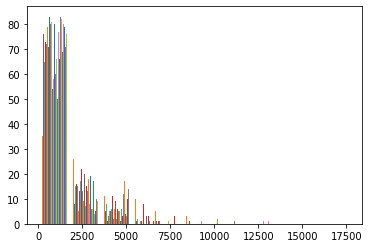

In [21]:
obs_var = np.var(data_rest,axis=1)
print(obs_var.shape)
print(obs_var.min())
print(obs_var.max())
plt.hist(obs_var)

In [11]:
ords = np.asarray(find_integration_order(data_rest))

Text(0.5, 0, 'Max Integration of ROIs: 0.0.')

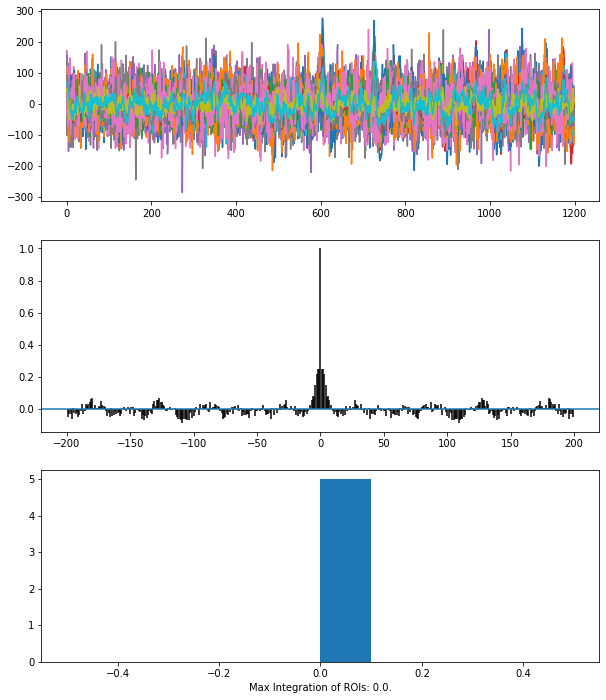

In [12]:
fig, ax = plt.subplots(3,1,figsize=(10,12))
for r in range(nroi):
    ax[0].plot(data_rest[0,:,r])

ax[1].acorr(data_rest[0,:,0], maxlags=200)
ax[2].hist(np.sum(ords,axis=1))
ax[2].set_xlabel("Max Integration of ROIs: {}.".format(np.max(ords.flatten())))

## PCA

In [11]:
f_all, U_all, epsilon_all = pca_everything(data_rest, algorithm="PCA", 
                                           n_components=nfactor)

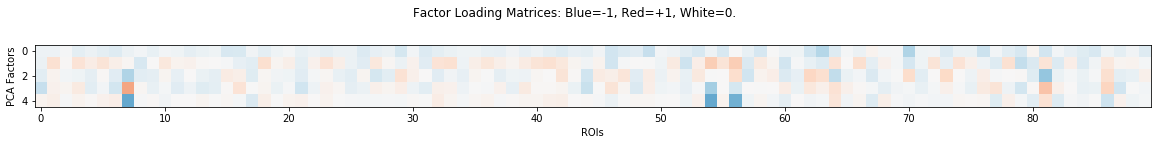

In [14]:
# compare factor loading matrices
fig, ax = plt.subplots(1,1,figsize=(20,2),sharex=True,sharey=True)
im1 = ax.imshow(U_all[0].T, vmin=-1, vmax=1)
im1.set_cmap('RdBu')
ax.set_ylabel('PCA Factors')
ax.set_xlabel('ROIs')
plt.suptitle("Factor Loading Matrices: Blue=-1, Red=+1, White=0.")
plt.show()

## Apply to Task Data

In [12]:
# Read data
wd = '/Users/meini/data/tfMRI_roi_mean/LANGUAGE'
filelist = [f for f in os.listdir(wd) if 'csv' in f]
data_task = []
nload = 5
for i in range(min(len(filelist), nload)):
    fpath = wd+'/'+filelist[i]
    data_task.append(np.genfromtxt(fpath, delimiter=',').T)

data_task = np.asarray(data_task) # nsub, ntime, nroi
print(data_task.shape)
nsub,ntime,nroi = data_task.shape

data_task = detrend(data_task)

(5, 316, 90)


Text(0.5, 0, 'Max Integration of ROIs: 1.0.')

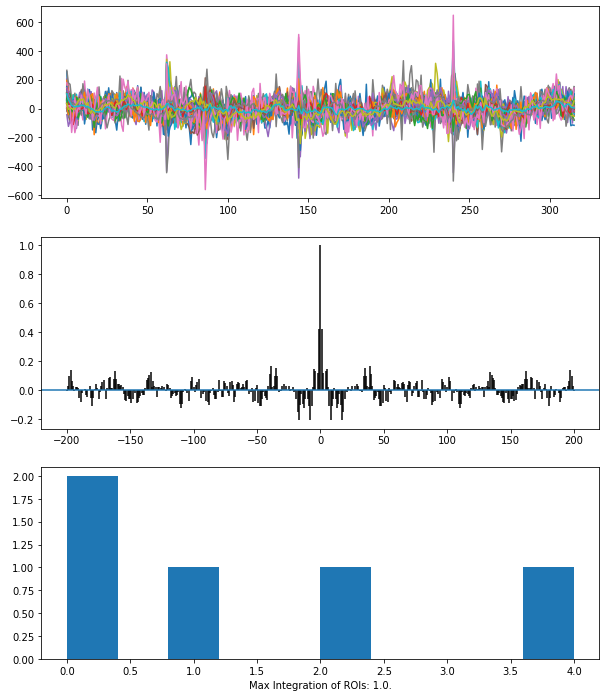

In [16]:
ords = np.asarray(find_integration_order(data_task))
fig, ax = plt.subplots(3,1,figsize=(10,12))
for r in range(nroi):
    ax[0].plot(data_task[0,:,r])

ax[1].acorr(data_task[0,:,0], maxlags=200)
ax[2].hist(np.sum(ords,axis=1))
ax[2].set_xlabel("Max Integration of ROIs: {}.".format(np.max(ords.flatten())))

In [17]:
f_task = []; epsilon_task = []
for s in range(data_task.shape[0]):
    f, epsilon = dynamic_factor_model(data_task[s,:,:].squeeze(), U_all[s])
    f_task.append(f)
    epsilon_task.append(epsilon)

Text(0.5, 0, 'Max Integration of ROIs: 1.0.')

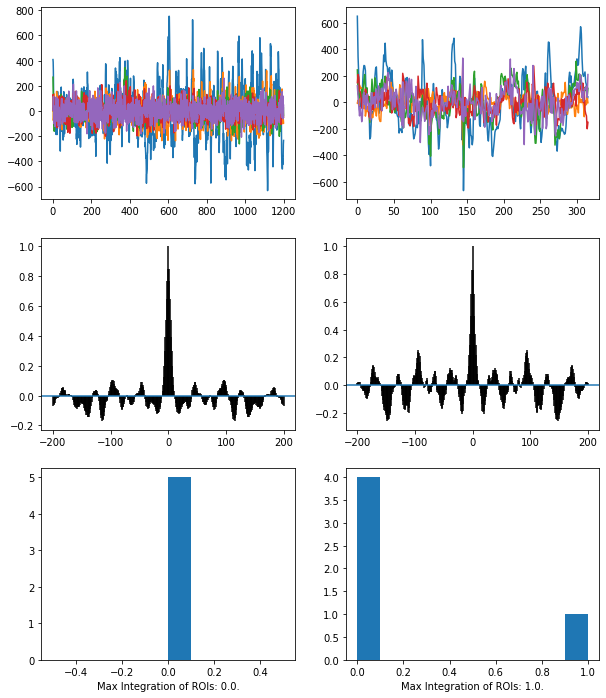

In [18]:
ords_rest = np.asarray(find_integration_order(f_all))
ords_task = np.asarray(find_integration_order(f_task))

fig, ax = plt.subplots(3,2,figsize=(10,12))
for r in range(nfactor):
    ax[0,0].plot(f_all[0][:,r])
    ax[0,1].plot(f_task[0][:,r])

ax[1,0].acorr(f_all[0][:,0], maxlags=200)
ax[2,0].hist(np.sum(ords_rest,axis=1))
ax[2,0].set_xlabel("Max Integration of ROIs: {}.".format(np.max(ords_rest.flatten())))

ax[1,1].acorr(f_task[0][:,0], maxlags=200)
ax[2,1].hist(np.sum(ords_task,axis=1))
ax[2,1].set_xlabel("Max Integration of ROIs: {}.".format(np.max(ords_task.flatten())))

For task-related data, we got some stationary factors and some I(1) integrated factors.

Anyway most of the PCA estimated dynamic factors are still stationary.

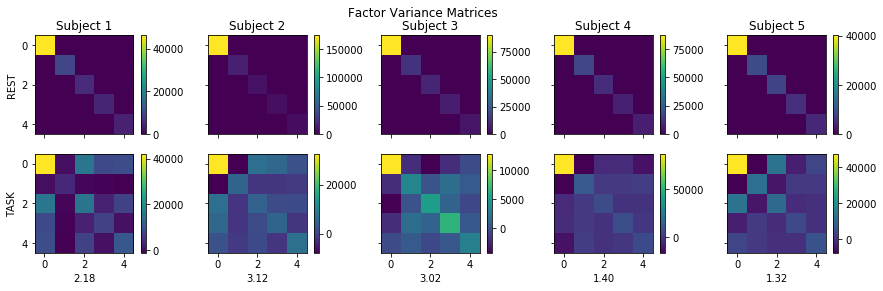

In [19]:
# compare factor variance matrices
fig, ax = plt.subplots(2,5, figsize=(15,4),sharex=True,sharey=True)
for s in range(5):
    im1 = ax[0,s].imshow(np.cov(f_all[s].T))
    plt.colorbar(im1, ax=ax[0,s])
    
    im2 = ax[1,s].imshow(np.cov(f_task[s].T))
    plt.colorbar(im2, ax=ax[1,s])
    
    ax[0,s].set_title("Subject {}".format(s+1))
    diff_f = matrix_global_diff(np.cov(f_all[s].T), np.cov(f_task[s].T))
    ax[1,s].set_xlabel("{:.2f}".format(diff_f))

ax[0,0].set_ylabel('REST')
ax[1,0].set_ylabel('TASK')
plt.suptitle('Factor Variance Matrices')
plt.show()

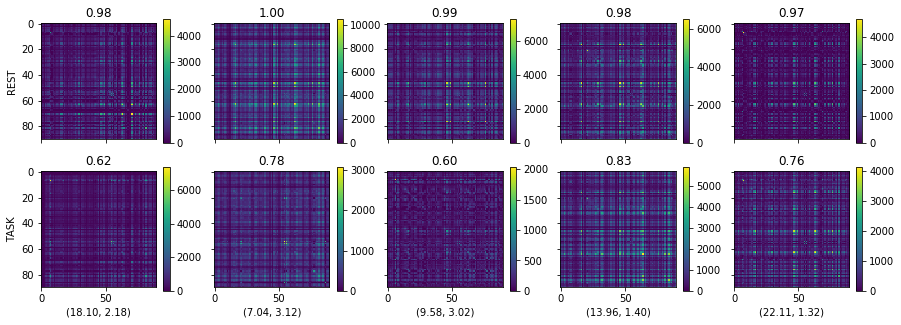

In [20]:
# Compare ROI level factor-related covariance
fig,ax = plt.subplots(2,5,figsize=(15,5),sharex=True,sharey=True)
for s in range(5):
    # resting
    dfm_rest = U_all[s] @ np.cov(f_all[s].T) @ U_all[s].T
    exp_pct = variance_explained(data_rest[s,:,:],U_all[s],f_all[s])
    
    im1 = ax[0,s].imshow(dfm_rest, vmin=0)
    ax[0,s].set_title("{:.2f}".format(exp_pct))
    plt.colorbar(im1, ax=ax[0,s])
    
    # Task
    dfm_task = U_all[s] @ np.cov(f_task[s].T) @ U_all[s].T
    exp_pct = variance_explained(data_task[s,:,:],U_all[s],f_task[s])
    
    im2 = ax[1,s].imshow(dfm_task, vmin=0)
    ax[1,s].set_title("{:.2f}".format(exp_pct))
    plt.colorbar(im2, ax=ax[1,s])
    
    diff = matrix_global_diff(dfm_rest,dfm_task)
    diff_f = matrix_global_diff(np.cov(f_all[s].T), np.cov(f_task[s].T))
    ax[1,s].set_xlabel("({:.2f}, {:.2f})".format(diff, diff_f))

ax[0,0].set_ylabel("REST")
ax[1,0].set_ylabel("TASK")
plt.show()

## Stochastic Volatility of Resting fMRI

0.0


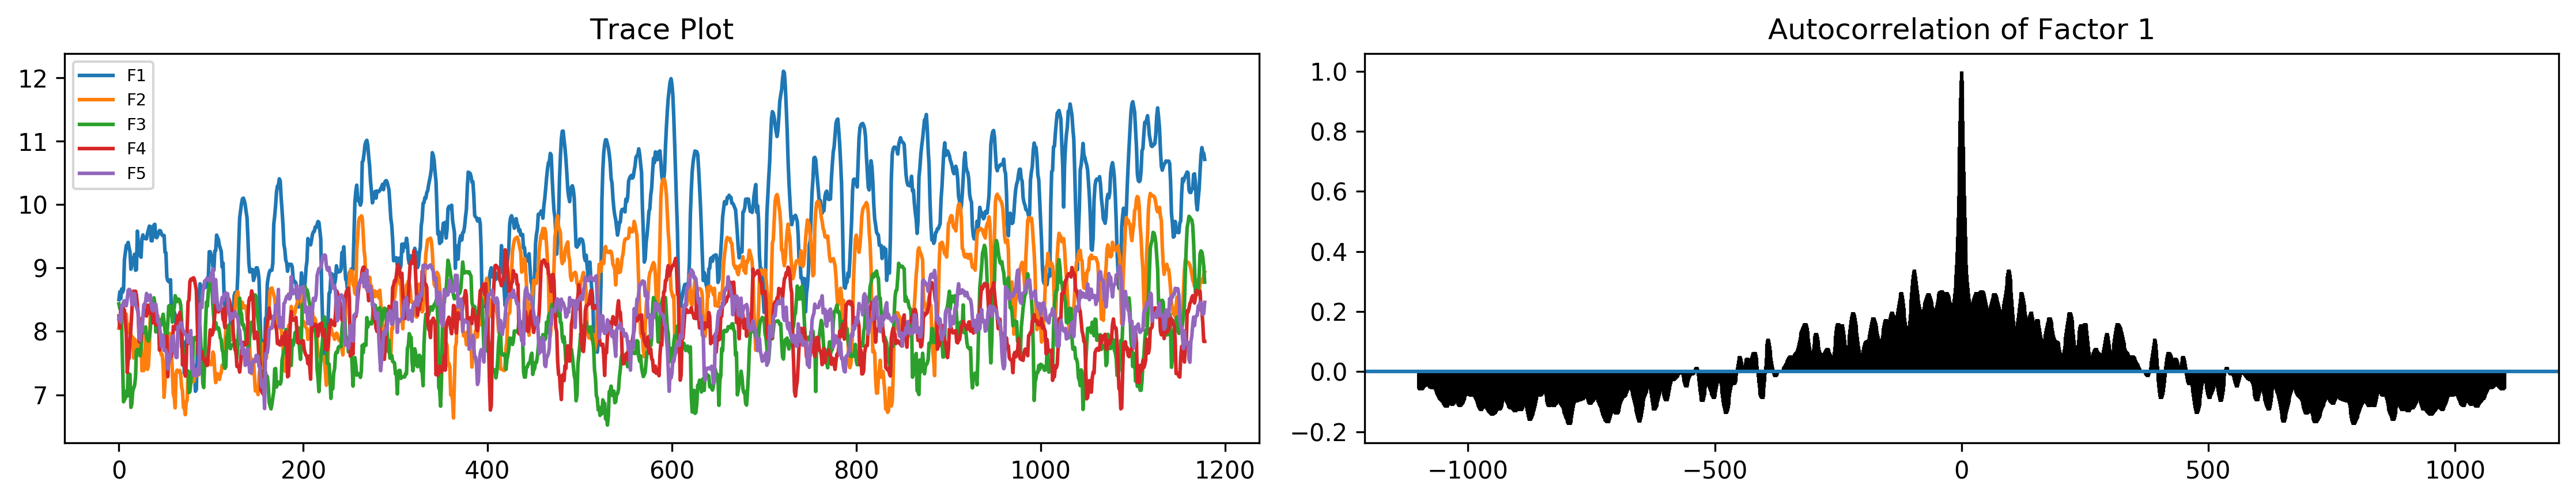

In [14]:
win_data = sliding_window(f_all[0].T, width=15, stepsize=1)
sv = calc_conn(win_data)[:,:,11:-10]
svl = [np.log(np.abs(sv[i,i,:])) for i in range(5)]
ords_sv = np.asarray(find_integration_order(svl))
print(np.max(ords_sv.T))

fig, ax = plt.subplots(1,2, figsize=(15,3), dpi=300)
for i in range(5):
    ax[0].plot(svl[i], label='F{}'.format(i+1))

ax[0].legend(loc='upper left', fontsize='x-small')
ax[0].set_title("Trace Plot")
    
ax[1].acorr(svl[0].flatten()-np.mean(svl[0].flatten()), maxlags=1100)
ax[1].set_title('Autocorrelation of Factor 1')
#ax[2].acorr(detrend(svl[0].flatten()-np.mean(svl[0].flatten()),
                    #normalize=True).squeeze(), maxlags=1100)
#ax[2].set_title('Autocorrelation of diff log factor volatilities')

fig.tight_layout()
fig.savefig('pca_empirical_logfac.png',dpi=300,transparent=True)

It shows that the logarithm of sample volatilities has no unit root, it is stationary or trend stationary.

In [40]:
print(adfuller(svl[0].flatten()-np.mean(svl[0].flatten())))
print(adfuller(detrend(svl[0].flatten()-np.mean(svl[0].flatten()),
                       normalize=True).squeeze()))

(-4.474769486434728, 0.00021834523596630135, 18, 1160, {'1%': -3.435999853208029, '5%': -2.864034810134692, '10%': -2.5680982944411417}, -647.2188086062406)
(-8.997928793743947, 6.616732582079904e-15, 5, 1173, {'1%': -3.435937099783359, '5%': -2.864007125872554, '10%': -2.5680835504811657}, -626.4120237029424)


## Factor Dynamic Stochastic Volatilities for resting data

It assumes that the nonstationary variance follows a stochastic process.

In [201]:
model = '''
data
{
    DY = dim(Y) # nroi x ntime
    DF = dim(U) # nroi x nfactor
}
model
{
    # Hierarchical Likelihood
    for (t in 1:DY[2]) {
        for (n in 1:DY[1]) {
            Y[n,t] ~ dnorm(U[n,]%*%Eta[,t], eps[n]) #2nd arg is precision
            # Y[n,t] ~ dnorm(U[n,]%*%Eta[,t], exp(lheps[n,t+1]/2)) #2nd arg is precision
            # lheps[n,t+1] ~ dnorm(mueps[n]+phieps[n]*(lheps[n,t]-mueps[n]), preceps[n])
        }

        for (p in 1:DF[2]) {
            Eta[p,t] ~ dnorm(0, exp(lheta[p,t+1]/2))
            lheta[p,t+1] ~ dnorm(mueta[p]+phieta[p]*(lheta[p,t]-mueta[p]), preceta[p])
        }
    }

    # Priors for the idiosyncratic variances
    for (n in 1:DY[1]) {
        eps[n] ~ dgamma(0.001,0.001)
        #lheps[n,1] ~ dnorm(mueps[n], preceps[n]*(1-phieps[n]^2))
        #mueps[n] ~ dnorm(0, 0.001)
        #phieps[n] = 2*zeps[n] - 1
        #zeps[n] ~ dbeta(20,1.5)
        #preceps[n] ~ dgamma(0.001,0.001) # inverse gamma
    }

    # Priors for the latent factors
    for (p in 1:DF[2]) {
        lheta[p,1] ~ dnorm(mueta[p], preceta[p]*(1-phieta[p]^2))
        mueta[p] ~ dnorm(0, 0.001)
        phieta[p] = 2*zeta[p] - 1
        zeta[p] ~ dbeta(20,1.5)
        preceta[p] ~ dgamma(0.001,0.001) # inverse gamma
    }
}
'''

In [196]:
U = U_all[0]
Y = data_rest[0,:,:].squeeze()
print(U.shape)
print(Y.shape)

(90, 5)
(1200, 90)


In [ ]:
results = pyjags.Model(model, data=dict(Y=Y.T,U=U), adapt=10000)
samples = results.sample(10000, vars=['mueta', 'mueps', 'phieta', 'phieps'])

It took eight hours to get the results...

## Restricted Factor Loading Matrices

In [ ]:
model = '''
data
{
    DY = dim(Y) # nroi x ntime
    nn = DY[1]
    nt = DY[2]
}
model
{
    # Hierarchical Likelihood
    for (t in 1:nt) {
        for (n in 1:nn) {
            Y[n,t] ~ dnorm(U[n,]%*%Eta[,t], eps[n]) #2nd arg is precision
            # Y[n,t] ~ dnorm(U[n,]%*%Eta[,t], exp(lheps[n,t+1]/2)) #2nd arg is precision
            # lheps[n,t+1] ~ dnorm(mueps[n]+phieps[n]*(lheps[n,t]-mueps[n]), preceps[n])
        }

        for (p in 1:np) {
            Eta[p,t] ~ dnorm(0, exp(lheta[p,t+1]/2))
            lheta[p,t+1] ~ dnorm(mueta[p]+phieta[p]*(lheta[p,t]-mueta[p]), preceta[p])
        }
    }

    # Priors for the idiosyncratic variances
    for (n in 1:nn) {
        eps[n] ~ dgamma(0.001,0.001)
        #lheps[n,1] ~ dnorm(mueps[n], preceps[n]*(1-phieps[n]^2))
        #mueps[n] ~ dnorm(0, 0.001)
        #phieps[n] = 2*zeps[n] - 1
        #zeps[n] ~ dbeta(20,1.5)
        #preceps[n] ~ dgamma(0.001,0.001) # inverse gamma
    }

    # Priors for the latent factors and factor loadings
    for (p in 1:np) {
        lheta[p,1] ~ dnorm(mueta[p], preceta[p]*(1-phieta[p]^2))
        mueta[p] ~ dnorm(0, 0.001)
        phieta[p] = 2*zeta[p] - 1
        zeta[p] ~ dbeta(18,1)
        preceta[p] ~ dgamma(0.001,0.001) # inverse gamma
    }
    
    # Priors for the factor loadings
    for (n in 1:nn) {
        for (p in 1:np) {
            # lower tri: norm rv
            # upper tri: 0
            # diagonal: 1
            indicator1[n,p] = ifelse(p<n, 1, 0) # is lower
            indicator2[n,p] = ifelse(p>n, 1, 0) # is upper
            U[n,p] = betarv[n,p]*indicator1[n,p] + 1*(1-indicator1[n,p])*(1-indicator2[n,p])
            betarv[n,p] ~ dnorm(1,1/25)
        }
    }
}
'''

In [ ]:
results = pyjags.Model(model, data=dict(Y=Y.T,np=5), adapt=10000, chains=1)
samples = results.sample(10000, vars=['phieta', 'mueta', 'U'])

If we assume factors are trend stationary...

In [ ]:
model = '''
data
{
    DY = dim(Y) # nroi x ntime
    nn = DY[1]
    nt = DY[2]
    TT = 1:(nt+1)
    T = (TT - mean(TT)) / sd(TT)
}
model
{
    # Hierarchical Likelihood
    for (t in 1:nt) {
        for (n in 1:nn) {
            Y[n,t] ~ dnorm(U[n,]%*%Eta[,t], eps[n]) #2nd arg is precision
            # Y[n,t] ~ dnorm(U[n,]%*%Eta[,t], exp(lheps[n,t+1]/2)) #2nd arg is precision
            # lheps[n,t+1] ~ dnorm(mueps[n]+phieps[n]*(lheps[n,t]-mueps[n]), preceps[n])
        }

        for (p in 1:np) {
            Eta[p,t] ~ dnorm(0, exp(lheta[p,t+1]/2))
            lheta[p,t+1] ~ dnorm(mueta[p]+alpha[p]*T[t+1]+phieta[p]*(lheta[p,t]-mueta[p]-alpha[p]*T[t]), preceta[p])
        }
    }

    # Priors for the idiosyncratic variances
    for (n in 1:nn) {
        eps[n] ~ dgamma(0.001,0.001)
        #lheps[n,1] ~ dnorm(mueps[n], preceps[n]*(1-phieps[n]^2))
        #mueps[n] ~ dnorm(0, 0.001)
        #phieps[n] = 2*zeps[n] - 1
        #zeps[n] ~ dbeta(20,1.5)
        #preceps[n] ~ dgamma(0.001,0.001) # inverse gamma
    }

    # Priors for the latent factors and factor loadings
    for (p in 1:np) {
        lheta[p,1] ~ dnorm(mueta[p]+alpha[p]*T[1], preceta[p]*(1-phieta[p]^2))
        mueta[p] ~ dnorm(0, 0.001)
        alpha[p] ~ dnorm(0, 0.001)
        phieta[p] = 2*zeta[p] - 1
        zeta[p] ~ dbeta(18,1)
        preceta[p] ~ dgamma(0.001,0.001) # inverse gamma
    }
    
    # Priors for the factor loadings
    for (n in 1:nn) {
        for (p in 1:np) {
            # lower tri: norm rv
            # upper tri: 0
            # diagonal: 1
            indicator1[n,p] = ifelse(p<n, 1, 0) # is lower
            indicator2[n,p] = ifelse(p>n, 1, 0) # is upper
            U[n,p] = betarv[n,p]*indicator1[n,p] + 1*(1-indicator1[n,p])*(1-indicator2[n,p])
            betarv[n,p] ~ dnorm(1,1/25)
        }
    }
}
'''

In [ ]:
results = pyjags.Model(model, data=dict(Y=Y.T,np=5), adapt=10000, chains=1)
samples = results.sample(10000, vars=['phieta', 'mueta', 'U', 'alpha'])